In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = mlp_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 dense (Dense)               (None, 100, 128)          6528      
                                                                 
 dense_1 (Dense)             (None, 100, 64)           8256      
                                                                 
 dense_2 (Dense)             (None, 100, 32)           2080      
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           231       
 ibuted)                                                         
                                                             

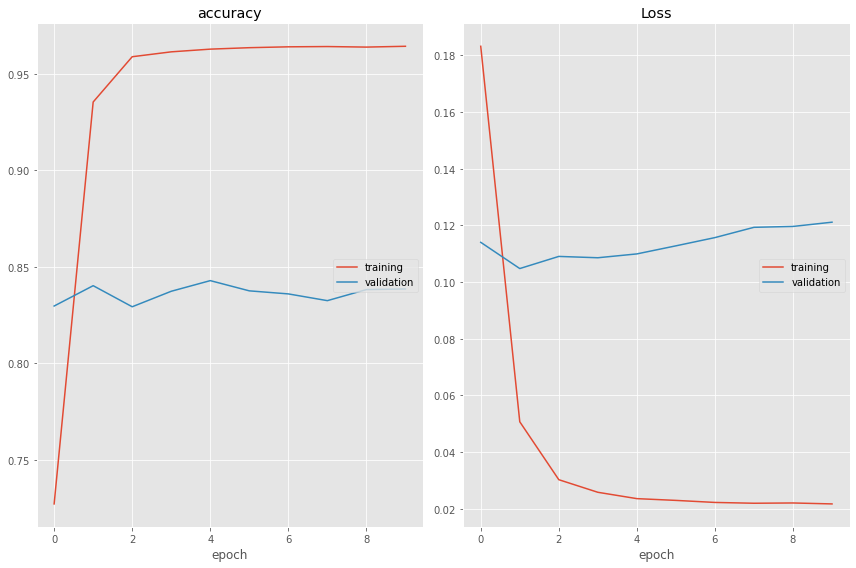

accuracy
	training         	 (min:    0.727, max:    0.964, cur:    0.964)
	validation       	 (min:    0.829, max:    0.843, cur:    0.839)
Loss
	training         	 (min:    0.022, max:    0.183, cur:    0.022)
	validation       	 (min:    0.105, max:    0.121, cur:    0.121)

Epoch 10: val_loss did not improve from 0.10479
56/56 [==============================] - 0s 3ms/step - loss: 0.1176 - accuracy: 0.8348
[0.11756383627653122, 0.8348283171653748]


In [8]:
root_path = 'model/'
model_name = 'mlp_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [9]:
from keras.models import load_model

mdl = load_model('model/mlp_model.h5')

In [10]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [11]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8838    0.8898    0.8868     22310
          JV     0.8963    0.5856    0.7084      4913
          EN     0.8707    0.7585    0.8107      5018
   MIX-ID-EN     0.9351    0.7852    0.8536       973
   MIX-ID-JV     0.9276    0.7321    0.8184       280
   MIX-JV-EN     0.7791    0.7256    0.7514       277
           O     0.7225    0.8956    0.7998     10153

    accuracy                         0.8378     43924
   macro avg     0.8593    0.7675    0.8042     43924
weighted avg     0.8472    0.8378    0.8360     43924



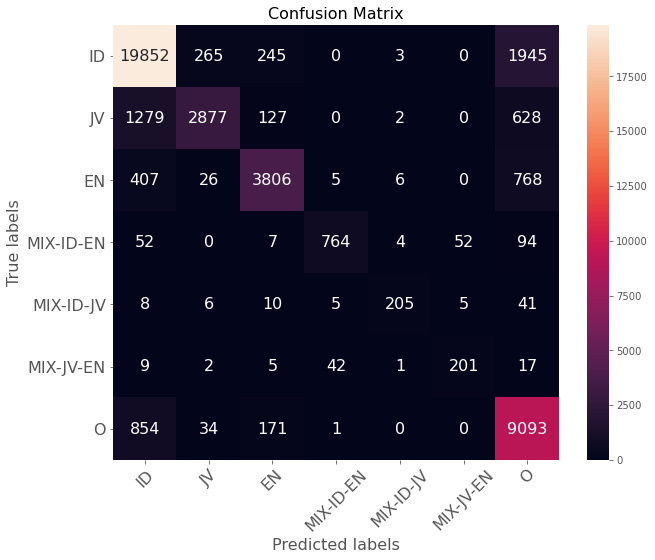

In [12]:
performance_report(true_flat, pred_flat)

In [13]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
@chiskekindomart              O         	O
seh                           JV        	JV
mending                       JV        	ID
,                             O         	O
isih                          JV        	JV
iso                           JV        	JV
discan                        MIX-JV-EN 	MIX-JV-EN
🥲                             O         	O
🥲                             O         	O
🥲                             O         	O


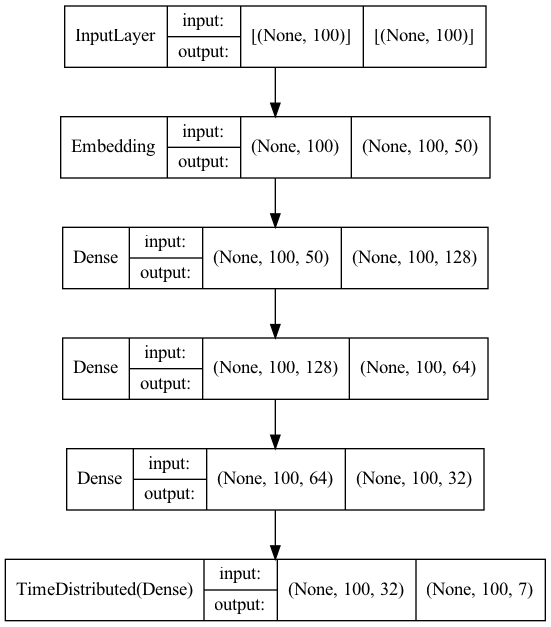

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_mlp.png', show_shapes=True, show_layer_names=False)